<a href="https://colab.research.google.com/github/iceaiai/CS-team/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python pillow
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=d7e9bdf7b245fe8f76aaa61df6495618c51b79680b3b6f054563a00bf901a8e9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=480609a83132796011107f03f89784879d3fb48146f6de9b3f041f184a350760
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

#1. Setup and Imports
Import all necessary libraries and ensure that the environment is correctly set up

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.transforms import *
from PIL import Image
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms, models
import os
import numpy as np
import kagglehub
import shutil


original_path = kagglehub.dataset_download("batuhanyil/electron-microscopy-particle-segmentation")
print("Original Path to dataset files:", original_path)
path = "/content/electron-microscopy-particle-segmentation"
shutil.move(original_path, path)
print(f"Dataset moved to: {path}")
!ls {path}

100%|██████████| 113M/113M [00:06<00:00, 18.8MB/s]

Extracting files...


Original Path to dataset files: /root/.cache/kagglehub/datasets/batuhanyil/electron-microscopy-particle-segmentation/versions/1
Dataset moved to: /content/electron-microscopy-particle-segmentation
images	segmaps


In [3]:
print("Contents of the dataset folder:")
print(os.listdir(path))

Contents of the dataset folder:
['images', 'segmaps']


#2.Configuration class or dictionary to make hyperparameters easily tunable
Note: 'image' folder contains SEM/TEM images. 'segmaps' contained the labelled masks.They are also available in our GT github.

In [5]:
class Config:
    # Data parameters
    image_folder = os.path.join(path, 'images')
    mask_folder = os.path.join(path, 'segmaps')
    resize = (512, 512) # it will be very painful if the image height and width are not the same!!!!

    # Training hyperparameters
    num_epochs = 50
    batch_size = 16
    learning_rate = 1e-4
    momentum = 0.9
    weight_decay = 5e-5

    # Model parameters
    num_classes = 1  # For binary segmentation
    kernel_size = 3
    stride = 1
    padding = 1

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print(f'current device = {config.device}')


current device = cuda


#3. Dataset preparation:


In [6]:
#Class for preparing data
class ImageDataset:
    def __init__(self, image_folder, mask_folder,transform =None,binary=False):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = sorted(os.listdir(image_folder))
        self.mask_files = sorted(os.listdir(mask_folder))
        self.transform = transform
        self.binary = binary
    def binary_transform(self, mask): # We only deal with one class
        # Transform mask to 1,0. 1 for masked area, 0 for not
        mask_array = np.array(mask)
        binary_mask = (mask_array != 0).astype(np.uint8)
        return Image.fromarray(binary_mask)

    def __len__(self): #Dunder method, usage: len(obj)
      return len(self.image_files)
    def __getitem__(self, idx): #Dunder method, usage: obj[idx]
      image_path = os.path.join(self.image_folder, self.image_files[idx])
      mask_path = os.path.join(self.mask_folder, self.mask_files[idx])
      image = Image.open(image_path).convert('L')
      mask = Image.open(mask_path).convert('L')
      if self.binary:
          mask = self.binary_transform(mask)
      if self.transform:
          image, mask = self.transform(image, mask)
      return image, mask
    def plot_figure(self, overlay=False, mask=True, binary=False, idx=None):
        """
        overlay: overlapping the original and masked images
        mask: display mask images
        idx: index or list of indices of the images to plot
        """
        if idx is None:
            idx = [0]
        elif isinstance(idx, int):
            idx = [idx]
        idx = [i for i in idx if i < len(self.image_files)]
        total_cols = 3 if mask and overlay else 2 if mask else 1
        total_rows = len(idx)
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(5 * total_cols, 5 * total_rows))

        if total_rows == 1:
            axes = [axes]

        for i, file_idx in enumerate(idx):
            img, mask_img = self[file_idx]

            # Convert tensors to numpy arrays
            img_np = img.squeeze(0).numpy()  # Squeeze channel for grayscale
            mask_np = mask_img.numpy()  # mask is already single-channel after transform

            ax_row = axes[i] if total_rows > 1 else axes

            # Display the image
            ax_row[0].imshow(img_np, cmap='gray')
            ax_row[0].set_title(f"Image {self.image_files[file_idx]}")
            ax_row[0].axis('off')

            if mask:
                # Display the mask
                ax_row[1].imshow(mask_np, cmap='inferno')
                ax_row[1].set_title(f"Mask {self.mask_files[file_idx]}")
                ax_row[1].axis('off')

                if overlay:
                    # Display the overlay
                    ax_row[2].imshow(img_np, cmap='gray', alpha=0.9)
                    ax_row[2].imshow(mask_np, cmap='inferno', alpha=0.4)
                    ax_row[2].set_title(f"Overlay {file_idx}")
                    ax_row[2].axis('off')

        plt.tight_layout()
        plt.show()

#Class for transforming data:
"""
  1. Resizing;
  2. Converting to tensor;
"""
class SegmentationTransform:
    def __init__(self, resize=None):
        self.resize = resize
        self.image_resize = transforms.Resize(resize)
        self.mask_resize = transforms.Resize(resize, interpolation=Image.NEAREST)

    def __call__(self, image, mask):
        image = self.image_resize(image)
        image_tensor = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        mask = self.mask_resize(mask)
        mask_array = np.array(mask)
        binary_mask = (mask_array > 0).astype(np.float32)
        mask_tensor = torch.tensor(binary_mask)
        return image_tensor, mask_tensor




#4. Data Loader

In [7]:
#Assign image and mask folder. Test the imagedata set class:
transform = SegmentationTransform(resize = config.resize) # can add resize if needed but not recommended
dataset = ImageDataset(config.image_folder, config.mask_folder, transform=transform, binary=True)
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Data loaders
"""
You can set:
batch size;
shuffle the data or not
num_workers: higher value speeding up the loading process.

"""

train_loader = DataLoader(train_dataset,
              batch_size=config.batch_size,
              shuffle=True,
              num_workers=4
              )
val_loader = DataLoader(val_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
test_loader = DataLoader(test_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )

#dataset.plot_figure(overlay=True, mask=True, binary=True,idx=[10,11,12,13,14,15,16,17,20, 21, 22, 23, 24, 25])

In [8]:
example_img1,example_mask1 = dataset[1]

example_mask1_np = np.array(example_mask1)
np.max(example_mask1_np)


1.0

# 5. Model preparation


##5.1 VGG-16


In [8]:
#Architectures of VGG-16:
"""
# input: (1,1,512,512)
(0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(1): ReLU(inplace=True)
(2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(3): ReLU(inplace=True)
(4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# Pool1(1,64,256,256)
(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(6): ReLU(inplace=True)
(7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(8): ReLU(inplace=True)
(9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)#Pool2 (1,128,128,128)
(10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(11): ReLU(inplace=True)
(12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(13): ReLU(inplace=True)
(14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(15): ReLU(inplace=True)
(16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool3 (1,256,64,64)
(17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(18): ReLU(inplace=True)
(19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(20): ReLU(inplace=True)
(21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(22): ReLU(inplace=True)
(23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool4(1,512,32,32)
(24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(25): ReLU(inplace=True)
(26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(27): ReLU(inplace=True)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace=True)
(30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool5(1,512,16,16)
)
"""
#FCN only, discard FCL
class FCN8s_VGG16(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s_VGG16, self).__init__()
        vgg = models.vgg16(pretrained=True) # VGG from pytorch

        vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) #remember we only have one channel not RGB, see [0] layer above
        #features = list(vgg.features.children())
        self.features = nn.Sequential(*list(vgg.features.children()))

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1) #convert 256 to number_class=1,dimension reduction
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1) #convert 512 to 1
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)  #convert 512 to 1

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2) #upsample to original data size *2
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2)#upsample to original data size *2
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, 8, stride=8)#upsample to original data size *8

    def forward(self, x):
        pool3 = self.features[:17](x)
        pool4 = self.features[17:24](pool3)
        pool5 = self.features[24:](pool4)
        score_fr = self.score_fr(pool5)#Reduces the depth of pool5 features to the number of classes using self.score_fr. (batch, num_classes, H/32, W/32)

        upscore2 = self.upscore2(score_fr) #upsample by 2 because of pool4 1,1,16,16 ->1,1,32,32 senmatic part (H-1)* stride + kernel_size - 2*[padding=0] = (16-1) *2 +2 =32
        score_pool4 = self.score_pool4(pool4) ## Shape: (batch, num_classes, H/16, W/16) spatial part
        fuse_pool4 = upscore2 + score_pool4 #semantic + spatial

        upscore_pool4 = self.upscore_pool4(fuse_pool4) #Shape: (batch, num_classes, H/8, W/8)
        score_pool3 = self.score_pool3(pool3)
        fuse_pool3 = upscore_pool4 + score_pool3

        out = self.upscore8(fuse_pool3)#1,1,512,512 (64-1) *8 +8 = 512
        return out

model = FCN8s_VGG16(num_classes=config.num_classes)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 241MB/s]


##5.2 ResNet-50

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, config.num_classes, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)

##5.3 U-Net

In [ ]:
import segmentation_models_pytorch as smp

Unet_model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g., resnet34
    encoder_weights='imagenet',     # Use pretrained weights from ImageNet
    in_channels=1,                  # Input channels (RGB images)
    classes=config.num_classes,     # Number of output classes
    encoder_depth=5,                # Tunable depth
    decoder_channels=[256, 128, 64, 32, 16],  # Tunable decoder channels
)
Unet_model = Unet_model.to(config.device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 83.7MB/s]


##5.4 DeepLabv3+


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 86.1MB/s]


## 5.5 Mask R CNN

##5.6 Res50-YNET

In [43]:
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Initialize weights
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        return x5, [x0, x1, x2, x3, x4]
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=3):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)
        )


    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)  # Corrected here
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # Squeeze
        y = F.adaptive_avg_pool2d(x, 1).view(batch, channels)
        # Excitation
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch, channels, 1, 1)
        return x * y
class YNetResNet34_Attention(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_Attention, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=5)
        self.bottleneck2 = Bottleneck(512, num_layers=5)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            SEBlock(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output

model = YNetResNet34_Attention(num_classes=1, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##5.7 Attention-Res-YNet

In [9]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        reduced_channels = max(1, in_channels // reduction)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, reduced_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return x * self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x
# Encoder with ResNet34 backbone
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)   # [B, 64, H/2, W/2]
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)  # [B, 64, H/4, W/4]
        x2 = self.layer1(x1)   # [B, 64, H/4, W/4]
        x3 = self.layer2(x2)   # [B, 128, H/8, W/8]
        x4 = self.layer3(x3)   # [B, 256, H/16, W/16]
        x5 = self.layer4(x4)   # [B, 512, H/32, W/32]
        return x5, [x0, x1, x2, x3, x4]
# Bottleneck with CBAM
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=4):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                CBAM(in_channels)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
# Decoder with CBAM
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            CBAM(out_channels)
        )

    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output
# Complete YNet with ResNet34 and CBAM
class YNetResNet34_CBAM(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_CBAM, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=4)
        self.bottleneck2 = Bottleneck(512, num_layers=4)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            CBAM(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output
model = YNetResNet34_CBAM(num_classes=config.num_classes, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 233MB/s]


#6. Training and testing

In [10]:
# learning rate customized
from torch.optim.lr_scheduler import LambdaLR

def custom_lr(epoch):
    if epoch < 20:
        return 1.0  # Keep the initial LR
    #elif 10 <= epoch < 20:
        #return 0.3
    elif 20 <= epoch < 30:
        return 0.5
    elif 30 <= epoch < 40:
        return 0.25
    #elif 50 <= epoch < 70:
        #return 0.1
    else:
        return 0.1

## reference https://www.kaggle.com/code/banddaniel/particle-segmentation-deeplabv3-test-dice-0-89
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - intersection
    return (intersection + smooth) / (union + smooth)
import torch.nn.functional as F

def boundary_loss(y_pred, y_true):
    # Ensure y_pred and y_true have the same number of channels
    assert y_pred.shape == y_true.shape, "Mismatch in shape"

    # Sobel filters
    sobel_kernel = torch.tensor([[[-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]],
                                 [[-1, -2, -1],
                                  [0, 0, 0],
                                  [1, 2, 1]]], dtype=torch.float32).to(y_pred.device)  # Shape: [2, 3, 3]
    sobel_kernel = sobel_kernel.unsqueeze(1)  # Shape: [2, 1, 3, 3]

    # Stack predictions and ground truths
    y_pred = torch.sigmoid(y_pred)  # Ensure y_pred is between 0 and 1
    y_true = y_true.float()

    # Compute gradients
    y_pred_grad = F.conv2d(y_pred, sobel_kernel, padding=1)
    y_true_grad = F.conv2d(y_true, sobel_kernel, padding=1)

    # Compute gradient magnitudes
    y_pred_grad_mag = torch.sqrt(y_pred_grad[:, 0] ** 2 + y_pred_grad[:, 1] ** 2 + 1e-7)
    y_true_grad_mag = torch.sqrt(y_true_grad[:, 0] ** 2 + y_true_grad[:, 1] ** 2 + 1e-7)

    # Compute L1 loss
    loss = F.l1_loss(y_pred_grad_mag, y_true_grad_mag)
    return loss




class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=1.0, weight_dice=1.0):#,weight_boundary =1.0):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        #self.weight_boundary = weight_boundary

    def forward(self, outputs, targets):
        bce_loss = self.bce(outputs, targets)
        probs = torch.sigmoid(outputs)
        dice_loss = dice_coef_loss(targets, probs)
        #boundary = boundary_loss(probs, targets)
        return self.weight_bce*bce_loss + self.weight_dice*dice_loss #+ self.weight_boundary*boundary
# BCE + DICE
criterion = CombinedLoss(weight_bce=10.0, weight_dice=1.0)#,weight_boundary=1.0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr)

##6.1 Training

In [11]:
from sklearn.metrics import adjusted_rand_score
num_epochs = config.num_epochs
train_loss_data = []
val_loss_data = []
precision_data = []
recall_data = []
accuracy_data = []
iou_data = []
f1_data = []
dice_coeff_data = []
rand_error_data = []
pixel_error_data = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(config.device)
        masks = masks.to(config.device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_dataset)
    train_loss_data.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    total_pixels = 0
    dice_coeff_sum = 0.0
    iou_sum = 0.0
    rand_error_sum = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(config.device)
            masks = masks.to(config.device)
            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            # Threshold probabilities to get binary predictions
            preds = (probs > 0.5).float()
            # Flatten tensors to calculate metrics
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            # Calculate TP, FP, TN, FN
            TP += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            FP += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            TN += ((preds_flat == 0) & (masks_flat == 0)).sum().item()
            FN += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            total_pixels += masks_flat.numel()
            # Use the dice_coef and jaccard_index functions
            dice_coeff = dice_coef(masks_flat, preds_flat).item()
            dice_coeff_sum += dice_coeff
            iou = jaccard_index(masks_flat, preds_flat).item()
            iou_sum += iou
            # Rand Error
            preds_np = preds_flat.cpu().numpy()
            masks_np = masks_flat.cpu().numpy()
            rand_error = 1 - adjusted_rand_score(masks_np, preds_np)
            rand_error_sum += rand_error

    val_loss /= len(val_dataset)
    val_loss_data.append(val_loss)

    # Calculate metrics
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    accuracy = (TP + TN) / (total_pixels + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    dice_coeff_avg = dice_coeff_sum / len(val_loader)
    iou_avg = iou_sum / len(val_loader)
    rand_error_avg = rand_error_sum / len(val_loader)
    pixel_error = (FP + FN) / (total_pixels + 1e-6)

    # Store metrics
    precision_data.append(precision)
    recall_data.append(recall)
    accuracy_data.append(accuracy)
    f1_data.append(f1_score)
    dice_coeff_data.append(dice_coeff_avg)
    iou_data.append(iou_avg)
    rand_error_data.append(rand_error_avg)
    pixel_error_data.append(pixel_error)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou_avg:.4f}, F1 Score: {f1_score:.4f}, Dice Coefficient: {dice_coeff_avg:.4f}")
    print(f"Pixel Error: {pixel_error:.4f}, Rand Error: {rand_error_avg:.4f}")



Epoch 1/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 1/50, Training Loss: 7.3977


Epoch 1/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


Epoch 1/50, Validation Loss: 7.7622
Precision: 0.3201, Recall: 1.0000, Accuracy: 0.3201
IoU: 0.3176, F1 Score: 0.4850, Dice Coefficient: 0.4780
Pixel Error: 0.6799, Rand Error: 1.0000


Epoch 2/50 - Training: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Epoch 2/50, Training Loss: 7.1635


Epoch 2/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


Epoch 2/50, Validation Loss: 7.6802
Precision: 0.3206, Recall: 0.9991, Accuracy: 0.3221
IoU: 0.3180, F1 Score: 0.4855, Dice Coefficient: 0.4784
Pixel Error: 0.6779, Rand Error: 1.0018


Epoch 3/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


Epoch 3/50, Training Loss: 6.3979


Epoch 3/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 3/50, Validation Loss: 6.7766
Precision: 0.5571, Recall: 0.9558, Accuracy: 0.7426
IoU: 0.5401, F1 Score: 0.7039, Dice Coefficient: 0.6980
Pixel Error: 0.2574, Rand Error: 0.7552


Epoch 4/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


Epoch 4/50, Training Loss: 5.3489


Epoch 4/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 4/50, Validation Loss: 5.3915
Precision: 0.8555, Recall: 0.9684, Accuracy: 0.9375
IoU: 0.8294, F1 Score: 0.9085, Dice Coefficient: 0.9052
Pixel Error: 0.0625, Rand Error: 0.2394


Epoch 5/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 5/50, Training Loss: 4.7219


Epoch 5/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 5/50, Validation Loss: 5.1084
Precision: 0.8869, Recall: 0.9659, Accuracy: 0.9496
IoU: 0.8573, F1 Score: 0.9247, Dice Coefficient: 0.9225
Pixel Error: 0.0504, Rand Error: 0.1960


Epoch 6/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


Epoch 6/50, Training Loss: 4.3597


Epoch 6/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Epoch 6/50, Validation Loss: 4.3654
Precision: 0.8858, Recall: 0.9750, Accuracy: 0.9518
IoU: 0.8634, F1 Score: 0.9283, Dice Coefficient: 0.9262
Pixel Error: 0.0482, Rand Error: 0.1877


Epoch 7/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 7/50, Training Loss: 4.0639


Epoch 7/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 7/50, Validation Loss: 4.1351
Precision: 0.9295, Recall: 0.9619, Accuracy: 0.9644
IoU: 0.8920, F1 Score: 0.9454, Dice Coefficient: 0.9423
Pixel Error: 0.0356, Rand Error: 0.1425


Epoch 8/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 8/50, Training Loss: 3.8661


Epoch 8/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Epoch 8/50, Validation Loss: 3.4921
Precision: 0.9137, Recall: 0.9817, Accuracy: 0.9645
IoU: 0.8967, F1 Score: 0.9465, Dice Coefficient: 0.9453
Pixel Error: 0.0355, Rand Error: 0.1404


Epoch 9/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


Epoch 9/50, Training Loss: 3.6338


Epoch 9/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


Epoch 9/50, Validation Loss: 3.6746
Precision: 0.9085, Recall: 0.9875, Accuracy: 0.9642
IoU: 0.8957, F1 Score: 0.9463, Dice Coefficient: 0.9447
Pixel Error: 0.0358, Rand Error: 0.1418


Epoch 10/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 10/50, Training Loss: 3.5025


Epoch 10/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.93s/it]


Epoch 10/50, Validation Loss: 3.5354
Precision: 0.9234, Recall: 0.9702, Accuracy: 0.9647
IoU: 0.8983, F1 Score: 0.9462, Dice Coefficient: 0.9462
Pixel Error: 0.0353, Rand Error: 0.1388


Epoch 11/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 11/50, Training Loss: 3.4374


Epoch 11/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Epoch 11/50, Validation Loss: 3.4082
Precision: 0.9410, Recall: 0.9666, Accuracy: 0.9699
IoU: 0.9111, F1 Score: 0.9536, Dice Coefficient: 0.9532
Pixel Error: 0.0301, Rand Error: 0.1195


Epoch 12/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


Epoch 12/50, Training Loss: 3.2882


Epoch 12/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.90s/it]


Epoch 12/50, Validation Loss: 3.3102
Precision: 0.9241, Recall: 0.9810, Accuracy: 0.9681
IoU: 0.9068, F1 Score: 0.9517, Dice Coefficient: 0.9509
Pixel Error: 0.0319, Rand Error: 0.1263


Epoch 13/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 13/50, Training Loss: 3.1575


Epoch 13/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 13/50, Validation Loss: 3.2177
Precision: 0.9408, Recall: 0.9751, Accuracy: 0.9724
IoU: 0.9176, F1 Score: 0.9576, Dice Coefficient: 0.9568
Pixel Error: 0.0276, Rand Error: 0.1103


Epoch 14/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 14/50, Training Loss: 3.0499


Epoch 14/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


Epoch 14/50, Validation Loss: 3.1014
Precision: 0.9356, Recall: 0.9793, Accuracy: 0.9718
IoU: 0.9163, F1 Score: 0.9569, Dice Coefficient: 0.9561
Pixel Error: 0.0282, Rand Error: 0.1125


Epoch 15/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 15/50, Training Loss: 2.9589


Epoch 15/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


Epoch 15/50, Validation Loss: 3.0080
Precision: 0.9314, Recall: 0.9838, Accuracy: 0.9716
IoU: 0.9151, F1 Score: 0.9569, Dice Coefficient: 0.9555
Pixel Error: 0.0284, Rand Error: 0.1134


Epoch 16/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 16/50, Training Loss: 2.9093


Epoch 16/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.95s/it]


Epoch 16/50, Validation Loss: 2.9923
Precision: 0.9333, Recall: 0.9850, Accuracy: 0.9726
IoU: 0.9180, F1 Score: 0.9584, Dice Coefficient: 0.9570
Pixel Error: 0.0274, Rand Error: 0.1096


Epoch 17/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 17/50, Training Loss: 2.8030


Epoch 17/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.95s/it]


Epoch 17/50, Validation Loss: 2.9534
Precision: 0.9332, Recall: 0.9840, Accuracy: 0.9723
IoU: 0.9174, F1 Score: 0.9579, Dice Coefficient: 0.9567
Pixel Error: 0.0277, Rand Error: 0.1107


Epoch 18/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 18/50, Training Loss: 2.7427


Epoch 18/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


Epoch 18/50, Validation Loss: 2.8680
Precision: 0.9337, Recall: 0.9837, Accuracy: 0.9724
IoU: 0.9179, F1 Score: 0.9581, Dice Coefficient: 0.9570
Pixel Error: 0.0276, Rand Error: 0.1101


Epoch 19/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 19/50, Training Loss: 2.7056


Epoch 19/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


Epoch 19/50, Validation Loss: 2.7405
Precision: 0.9373, Recall: 0.9788, Accuracy: 0.9723
IoU: 0.9177, F1 Score: 0.9576, Dice Coefficient: 0.9569
Pixel Error: 0.0277, Rand Error: 0.1105


Epoch 20/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 20/50, Training Loss: 2.6632


Epoch 20/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 20/50, Validation Loss: 2.7542
Precision: 0.9459, Recall: 0.9660, Accuracy: 0.9714
IoU: 0.9160, F1 Score: 0.9558, Dice Coefficient: 0.9560
Pixel Error: 0.0286, Rand Error: 0.1134


Epoch 21/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 21/50, Training Loss: 2.5408


Epoch 21/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 21/50, Validation Loss: 2.7637
Precision: 0.9486, Recall: 0.9723, Accuracy: 0.9743
IoU: 0.9232, F1 Score: 0.9603, Dice Coefficient: 0.9599
Pixel Error: 0.0257, Rand Error: 0.1029


Epoch 22/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 22/50, Training Loss: 2.5771


Epoch 22/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 22/50, Validation Loss: 2.8026
Precision: 0.9465, Recall: 0.9763, Accuracy: 0.9748
IoU: 0.9243, F1 Score: 0.9612, Dice Coefficient: 0.9604
Pixel Error: 0.0252, Rand Error: 0.1010


Epoch 23/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 23/50, Training Loss: 2.5133


Epoch 23/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


Epoch 23/50, Validation Loss: 2.6374
Precision: 0.9476, Recall: 0.9777, Accuracy: 0.9756
IoU: 0.9265, F1 Score: 0.9624, Dice Coefficient: 0.9617
Pixel Error: 0.0244, Rand Error: 0.0979


Epoch 24/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 24/50, Training Loss: 2.4867


Epoch 24/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


Epoch 24/50, Validation Loss: 2.7385
Precision: 0.9402, Recall: 0.9834, Accuracy: 0.9747
IoU: 0.9240, F1 Score: 0.9613, Dice Coefficient: 0.9603
Pixel Error: 0.0253, Rand Error: 0.1015


Epoch 25/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 25/50, Training Loss: 2.4207


Epoch 25/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 25/50, Validation Loss: 2.6185
Precision: 0.9458, Recall: 0.9771, Accuracy: 0.9747
IoU: 0.9246, F1 Score: 0.9612, Dice Coefficient: 0.9606
Pixel Error: 0.0253, Rand Error: 0.1010


Epoch 26/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 26/50, Training Loss: 2.4097


Epoch 26/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 26/50, Validation Loss: 2.5524
Precision: 0.9460, Recall: 0.9798, Accuracy: 0.9756
IoU: 0.9267, F1 Score: 0.9626, Dice Coefficient: 0.9618
Pixel Error: 0.0244, Rand Error: 0.0978


Epoch 27/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 27/50, Training Loss: 2.3743


Epoch 27/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Epoch 27/50, Validation Loss: 2.5385
Precision: 0.9478, Recall: 0.9780, Accuracy: 0.9757
IoU: 0.9270, F1 Score: 0.9627, Dice Coefficient: 0.9619
Pixel Error: 0.0243, Rand Error: 0.0973


Epoch 28/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 28/50, Training Loss: 2.3155


Epoch 28/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 28/50, Validation Loss: 2.5071
Precision: 0.9478, Recall: 0.9786, Accuracy: 0.9759
IoU: 0.9272, F1 Score: 0.9629, Dice Coefficient: 0.9620
Pixel Error: 0.0241, Rand Error: 0.0968


Epoch 29/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 29/50, Training Loss: 2.3297


Epoch 29/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


Epoch 29/50, Validation Loss: 2.5379
Precision: 0.9425, Recall: 0.9824, Accuracy: 0.9752
IoU: 0.9257, F1 Score: 0.9621, Dice Coefficient: 0.9613
Pixel Error: 0.0248, Rand Error: 0.0993


Epoch 30/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 30/50, Training Loss: 2.3008


Epoch 30/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.93s/it]


Epoch 30/50, Validation Loss: 2.5022
Precision: 0.9481, Recall: 0.9793, Accuracy: 0.9762
IoU: 0.9283, F1 Score: 0.9635, Dice Coefficient: 0.9626
Pixel Error: 0.0238, Rand Error: 0.0954


Epoch 31/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 31/50, Training Loss: 2.2476


Epoch 31/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


Epoch 31/50, Validation Loss: 2.4625
Precision: 0.9522, Recall: 0.9769, Accuracy: 0.9769
IoU: 0.9301, F1 Score: 0.9644, Dice Coefficient: 0.9636
Pixel Error: 0.0231, Rand Error: 0.0928


Epoch 32/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 32/50, Training Loss: 2.2354


Epoch 32/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 32/50, Validation Loss: 2.4342
Precision: 0.9541, Recall: 0.9754, Accuracy: 0.9771
IoU: 0.9307, F1 Score: 0.9646, Dice Coefficient: 0.9639
Pixel Error: 0.0229, Rand Error: 0.0920


Epoch 33/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 33/50, Training Loss: 2.2849


Epoch 33/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 33/50, Validation Loss: 2.4213
Precision: 0.9522, Recall: 0.9756, Accuracy: 0.9765
IoU: 0.9294, F1 Score: 0.9638, Dice Coefficient: 0.9632
Pixel Error: 0.0235, Rand Error: 0.0941


Epoch 34/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 34/50, Training Loss: 2.2643


Epoch 34/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.93s/it]


Epoch 34/50, Validation Loss: 2.4690
Precision: 0.9393, Recall: 0.9846, Accuracy: 0.9747
IoU: 0.9245, F1 Score: 0.9614, Dice Coefficient: 0.9606
Pixel Error: 0.0253, Rand Error: 0.1012


Epoch 35/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 35/50, Training Loss: 2.2392


Epoch 35/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.93s/it]


Epoch 35/50, Validation Loss: 2.5045
Precision: 0.9427, Recall: 0.9831, Accuracy: 0.9754
IoU: 0.9265, F1 Score: 0.9625, Dice Coefficient: 0.9617
Pixel Error: 0.0246, Rand Error: 0.0983


Epoch 36/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 36/50, Training Loss: 2.1884


Epoch 36/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.93s/it]


Epoch 36/50, Validation Loss: 2.4370
Precision: 0.9438, Recall: 0.9824, Accuracy: 0.9756
IoU: 0.9270, F1 Score: 0.9627, Dice Coefficient: 0.9619
Pixel Error: 0.0244, Rand Error: 0.0976


Epoch 37/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 37/50, Training Loss: 2.1812


Epoch 37/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.93s/it]


Epoch 37/50, Validation Loss: 2.4306
Precision: 0.9454, Recall: 0.9817, Accuracy: 0.9760
IoU: 0.9279, F1 Score: 0.9632, Dice Coefficient: 0.9624
Pixel Error: 0.0240, Rand Error: 0.0963


Epoch 38/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 38/50, Training Loss: 2.2094


Epoch 38/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.95s/it]


Epoch 38/50, Validation Loss: 2.4079
Precision: 0.9454, Recall: 0.9817, Accuracy: 0.9760
IoU: 0.9280, F1 Score: 0.9632, Dice Coefficient: 0.9625
Pixel Error: 0.0240, Rand Error: 0.0962


Epoch 39/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 39/50, Training Loss: 2.1657


Epoch 39/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.90s/it]


Epoch 39/50, Validation Loss: 2.4273
Precision: 0.9438, Recall: 0.9830, Accuracy: 0.9758
IoU: 0.9275, F1 Score: 0.9630, Dice Coefficient: 0.9622
Pixel Error: 0.0242, Rand Error: 0.0969


Epoch 40/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 40/50, Training Loss: 2.1514


Epoch 40/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Epoch 40/50, Validation Loss: 2.3724
Precision: 0.9454, Recall: 0.9821, Accuracy: 0.9761
IoU: 0.9285, F1 Score: 0.9634, Dice Coefficient: 0.9627
Pixel Error: 0.0239, Rand Error: 0.0956


Epoch 41/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 41/50, Training Loss: 2.1372


Epoch 41/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Epoch 41/50, Validation Loss: 2.3522
Precision: 0.9480, Recall: 0.9809, Accuracy: 0.9767
IoU: 0.9299, F1 Score: 0.9642, Dice Coefficient: 0.9635
Pixel Error: 0.0233, Rand Error: 0.0935


Epoch 42/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 42/50, Training Loss: 2.1355


Epoch 42/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.95s/it]


Epoch 42/50, Validation Loss: 2.3663
Precision: 0.9502, Recall: 0.9799, Accuracy: 0.9771
IoU: 0.9310, F1 Score: 0.9648, Dice Coefficient: 0.9641
Pixel Error: 0.0229, Rand Error: 0.0919


Epoch 43/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 43/50, Training Loss: 2.1475


Epoch 43/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Epoch 43/50, Validation Loss: 2.3881
Precision: 0.9458, Recall: 0.9826, Accuracy: 0.9764
IoU: 0.9291, F1 Score: 0.9638, Dice Coefficient: 0.9631
Pixel Error: 0.0236, Rand Error: 0.0946


Epoch 44/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 44/50, Training Loss: 2.1294


Epoch 44/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


Epoch 44/50, Validation Loss: 2.3435
Precision: 0.9563, Recall: 0.9734, Accuracy: 0.9772
IoU: 0.9314, F1 Score: 0.9647, Dice Coefficient: 0.9643
Pixel Error: 0.0228, Rand Error: 0.0913


Epoch 45/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 45/50, Training Loss: 2.0994


Epoch 45/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 45/50, Validation Loss: 2.2839
Precision: 0.9570, Recall: 0.9728, Accuracy: 0.9773
IoU: 0.9315, F1 Score: 0.9648, Dice Coefficient: 0.9643
Pixel Error: 0.0227, Rand Error: 0.0911


Epoch 46/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 46/50, Training Loss: 2.1037


Epoch 46/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 46/50, Validation Loss: 2.3074
Precision: 0.9506, Recall: 0.9788, Accuracy: 0.9769
IoU: 0.9306, F1 Score: 0.9645, Dice Coefficient: 0.9639
Pixel Error: 0.0231, Rand Error: 0.0924


Epoch 47/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 47/50, Training Loss: 2.0917


Epoch 47/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Epoch 47/50, Validation Loss: 2.3330
Precision: 0.9479, Recall: 0.9804, Accuracy: 0.9765
IoU: 0.9294, F1 Score: 0.9639, Dice Coefficient: 0.9632
Pixel Error: 0.0235, Rand Error: 0.0942


Epoch 48/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 48/50, Training Loss: 2.0977


Epoch 48/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Epoch 48/50, Validation Loss: 2.3538
Precision: 0.9475, Recall: 0.9809, Accuracy: 0.9765
IoU: 0.9293, F1 Score: 0.9639, Dice Coefficient: 0.9632
Pixel Error: 0.0235, Rand Error: 0.0943


Epoch 49/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 49/50, Training Loss: 2.0782


Epoch 49/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Epoch 49/50, Validation Loss: 2.3115
Precision: 0.9520, Recall: 0.9769, Accuracy: 0.9768
IoU: 0.9306, F1 Score: 0.9643, Dice Coefficient: 0.9639
Pixel Error: 0.0232, Rand Error: 0.0927


Epoch 50/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 50/50, Training Loss: 2.0930


Epoch 50/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.90s/it]

Epoch 50/50, Validation Loss: 2.3079
Precision: 0.9507, Recall: 0.9785, Accuracy: 0.9769
IoU: 0.9306, F1 Score: 0.9644, Dice Coefficient: 0.9639
Pixel Error: 0.0231, Rand Error: 0.0926


##6.2 Testing



In [12]:
model.eval()
test_loss = 0.0

# Initialize lists for metrics with "data_testing" prefix
precision_data_testing = []
recall_data_testing = []
accuracy_data_testing = []
iou_data_testing = []
f1_data_testing = []
dice_coeff_data_testing = []
rand_error_data_testing = []
pixel_error_data_testing = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(config.device)
        masks = masks.to(config.device)

        # Forward pass
        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        outputs = outputs.squeeze(1)

        # Calculate loss
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

        # Threshold predictions for metrics (e.g., using 0.5 as the threshold)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        # Calculate metrics
        tp = (preds * masks).sum().item()  # True Positives
        fp = (preds * (1 - masks)).sum().item()  # False Positives
        fn = ((1 - preds) * masks).sum().item()  # False Negatives
        tn = ((1 - preds) * (1 - masks)).sum().item()  # True Negatives

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-6)
        iou = tp / (tp + fp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        dice_coeff = 2 * tp / (2 * tp + fp + fn + 1e-6)
        pixel_error = 1 - accuracy
        rand_error = 1 - (tp + tn) / (tp + fp + fn + tn + 1e-6)

        # Append metrics to lists
        precision_data_testing.append(precision)
        recall_data_testing.append(recall)
        accuracy_data_testing.append(accuracy)
        iou_data_testing.append(iou)
        f1_data_testing.append(f1)
        dice_coeff_data_testing.append(dice_coeff)
        pixel_error_data_testing.append(pixel_error)
        rand_error_data_testing.append(rand_error)

# Compute average test loss
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# Compute average metrics
avg_precision = sum(precision_data_testing) / len(precision_data_testing)
avg_recall = sum(recall_data_testing) / len(recall_data_testing)
avg_accuracy = sum(accuracy_data_testing) / len(accuracy_data_testing)
avg_iou = sum(iou_data_testing) / len(iou_data_testing)
avg_f1 = sum(f1_data_testing) / len(f1_data_testing)
avg_dice_coeff = sum(dice_coeff_data_testing) / len(dice_coeff_data_testing)
avg_pixel_error = sum(pixel_error_data_testing) / len(pixel_error_data_testing)
avg_rand_error = sum(rand_error_data_testing) / len(rand_error_data_testing)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Dice Coefficient: {avg_dice_coeff:.4f}")
print(f"Average Pixel Error: {avg_pixel_error:.4f}")
print(f"Average Rand Error: {avg_rand_error:.4f}")


Testing: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

Test Loss: 2.5362
Average Precision: 0.9320
Average Recall: 0.9533
Average Accuracy: 0.9660
Average IoU: 0.8924
Average F1 Score: 0.9422
Average Dice Coefficient: 0.9422
Average Pixel Error: 0.0340
Average Rand Error: 0.0340


In [13]:
import pandas as pd

results_data = {
    "precision": precision_data_testing,
    "recall": recall_data_testing,
    "accuracy": accuracy_data_testing,
    "iou": iou_data_testing,
    "f1": f1_data_testing,
    "dice_coeff": dice_coeff_data_testing,
    "pixel_error": pixel_error_data_testing,
    "rand_error": rand_error_data_testing
}

# Convert to DataFrame
results_df = pd.DataFrame(results_data)

# Compute average metrics and append to the DataFrame
average_row = {
    "precision": sum(precision_data_testing) / len(precision_data_testing),
    "recall": sum(recall_data_testing) / len(recall_data_testing),
    "accuracy": sum(accuracy_data_testing) / len(accuracy_data_testing),
    "iou": sum(iou_data_testing) / len(iou_data_testing),
    "f1": sum(f1_data_testing) / len(f1_data_testing),
    "dice_coeff": sum(dice_coeff_data_testing) / len(dice_coeff_data_testing),
    "pixel_error": sum(pixel_error_data_testing) / len(pixel_error_data_testing),
    "rand_error": sum(rand_error_data_testing) / len(rand_error_data_testing)
}

average_row_df = pd.DataFrame([average_row])
results_df = pd.concat([results_df, average_row_df], ignore_index=True)
results_df.loc[len(results_df) - 1, 'epoch'] = 'Average'
results_df.to_csv("testing_results.csv", index=False)


##6.3 Saving and loading the model

In [14]:
# Save the model
torch.save(model.state_dict(), 'Ynet34-atten_model.pth')

# Load the model
model.load_state_dict(torch.load('Ynet34-atten_model.pth'))
model.eval()

<ipython-input-14-4c799bb9b1d1>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Ynet34-atten_model.pth'))


YNetResNet34_CBAM(
  (encoder): ResNet34Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

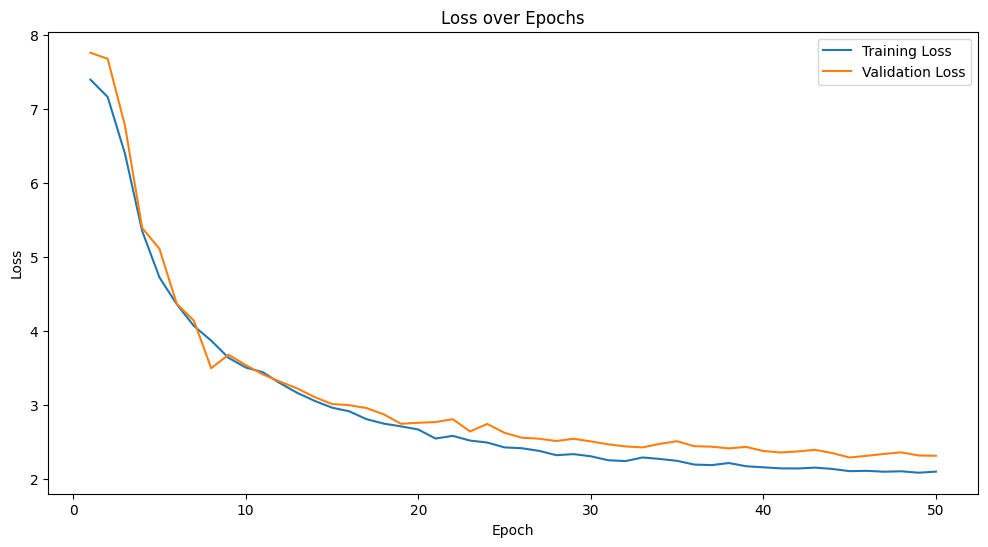

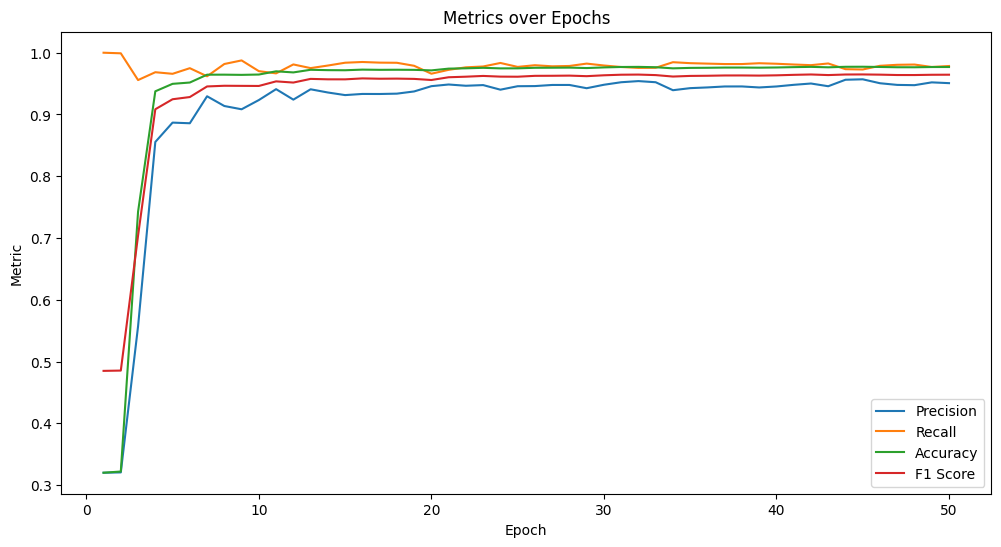

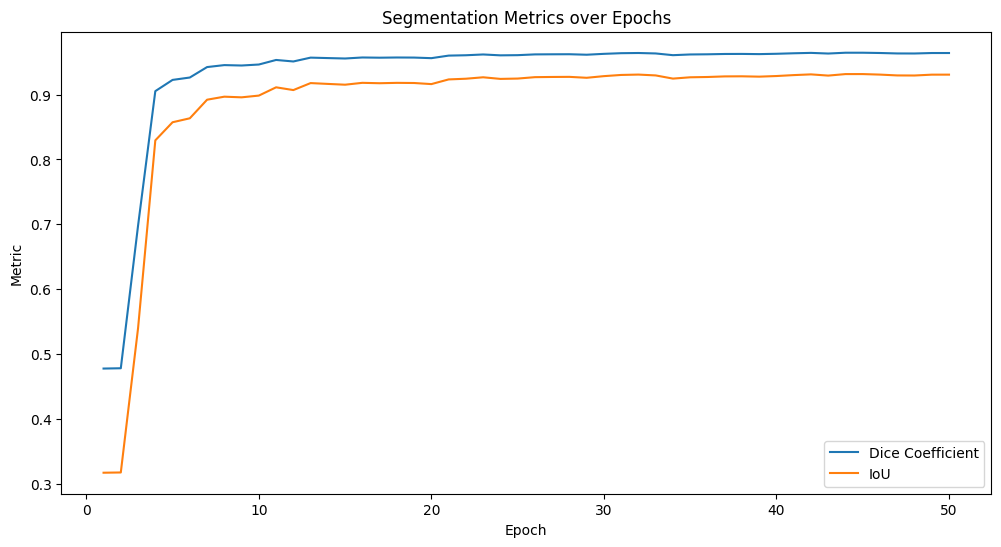

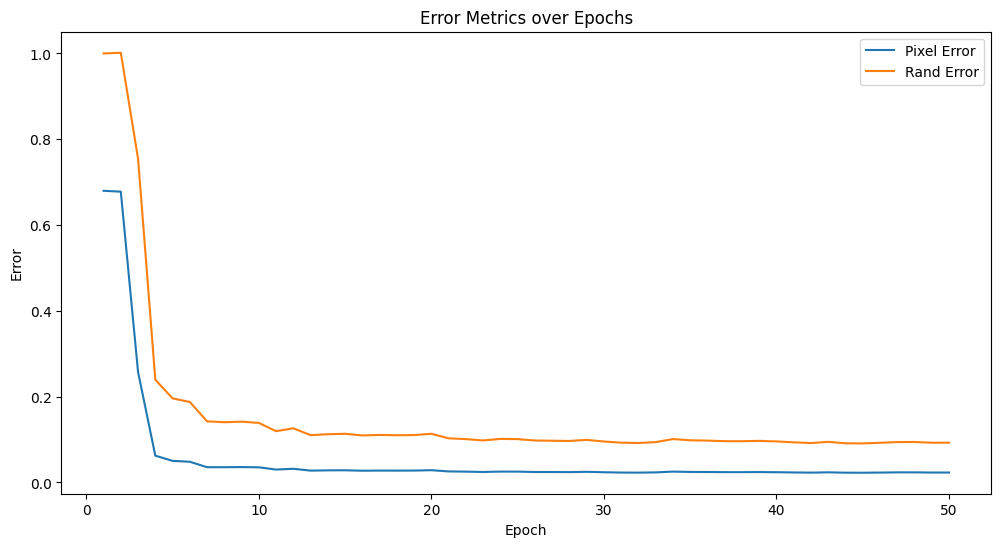

In [15]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_data, label='Training Loss')
plt.plot(epochs, val_loss_data, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.savefig('loss.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_data, label='Precision')
plt.plot(epochs, recall_data, label='Recall')
plt.plot(epochs, accuracy_data, label='Accuracy')
plt.plot(epochs, f1_data, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Metrics over Epochs')
plt.savefig('metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, dice_coeff_data, label='Dice Coefficient')
plt.plot(epochs, iou_data, label='IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Segmentation Metrics over Epochs')
plt.savefig('segmentation_metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, pixel_error_data, label='Pixel Error')
plt.plot(epochs, rand_error_data, label='Rand Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title('Error Metrics over Epochs')
plt.savefig('error_metrics.png')
plt.show()



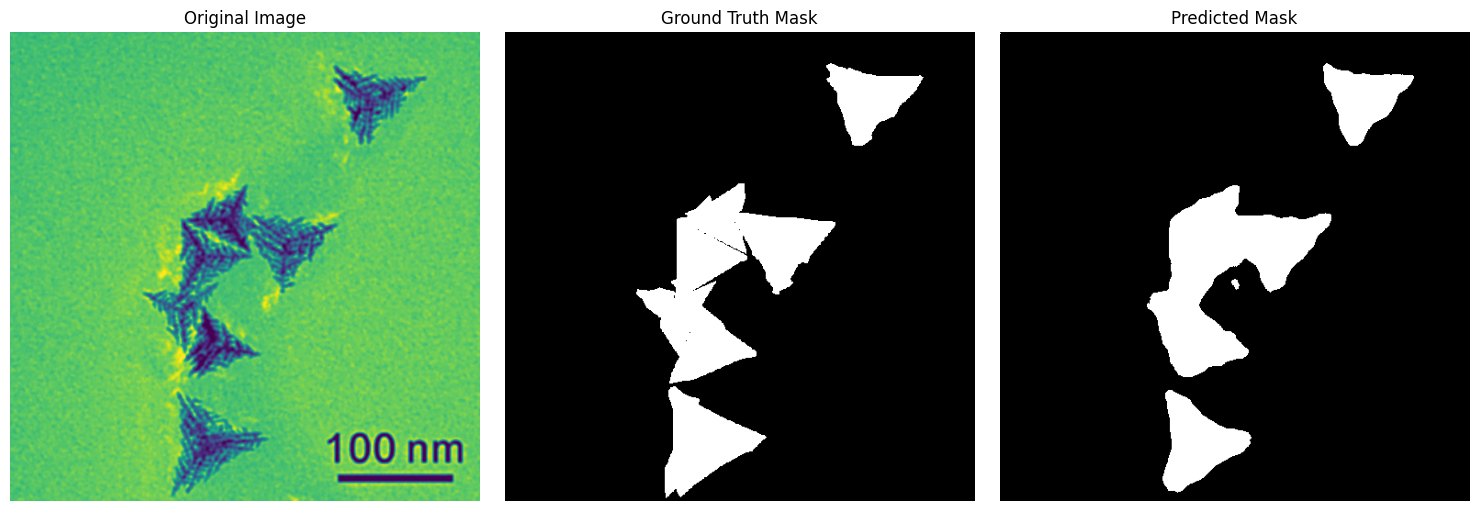

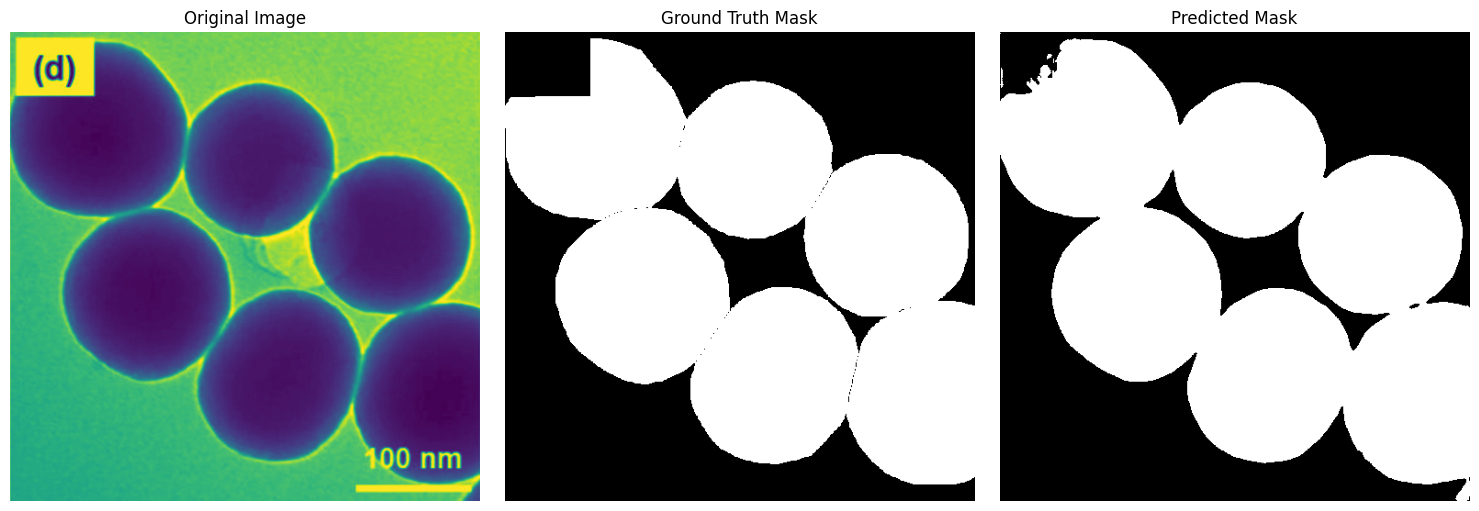

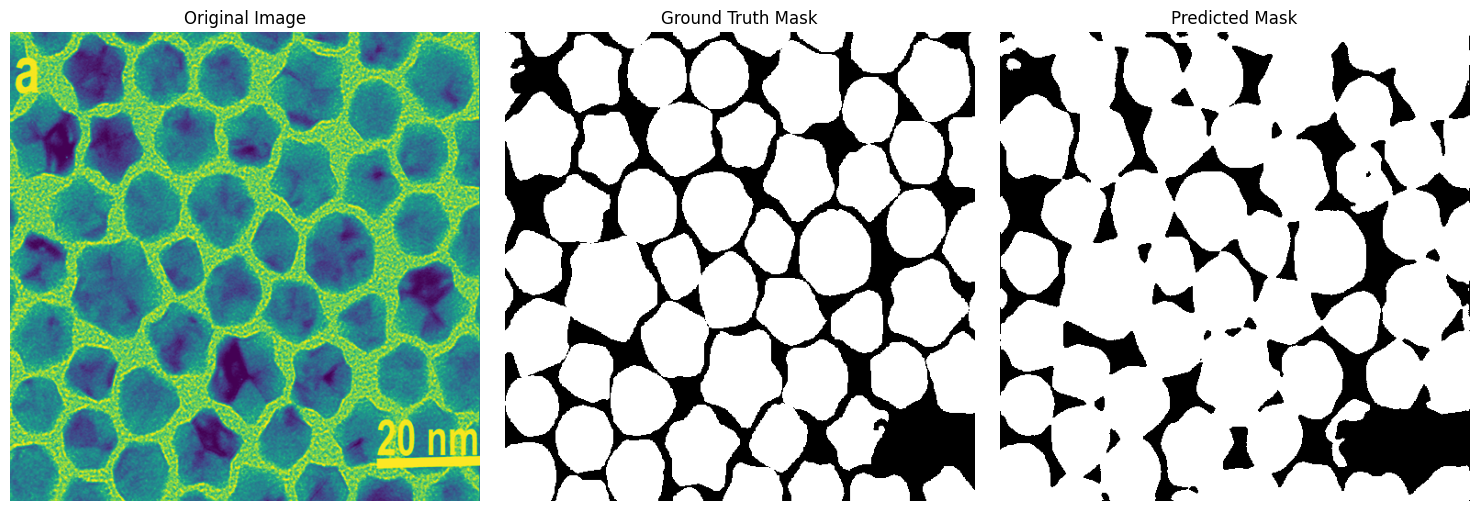

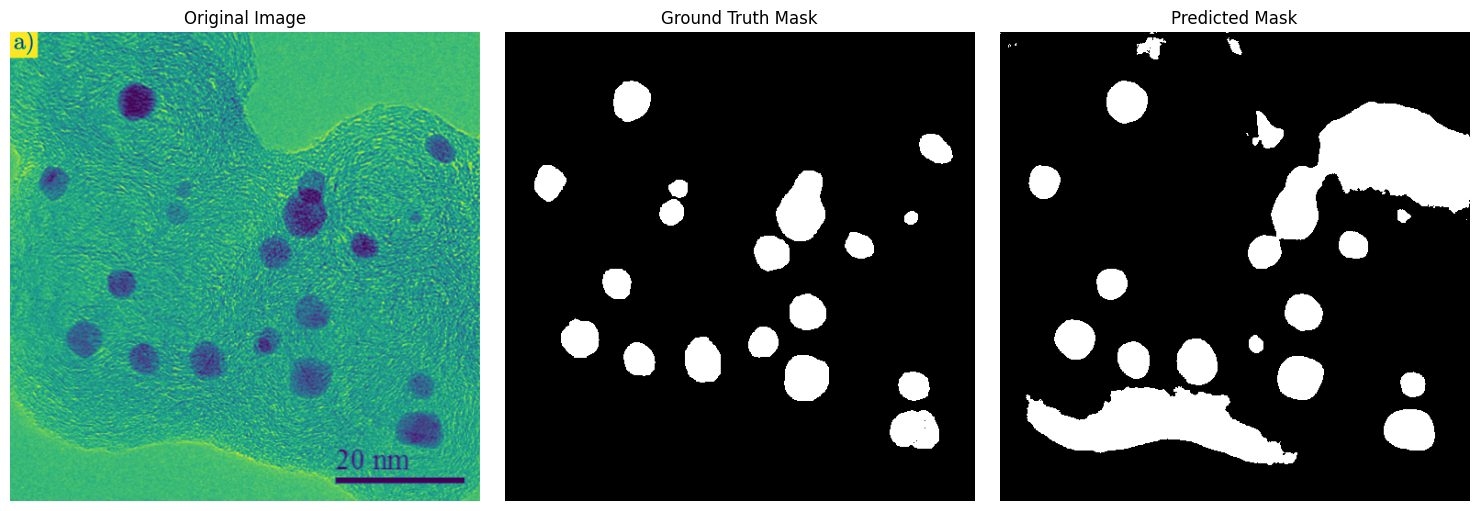

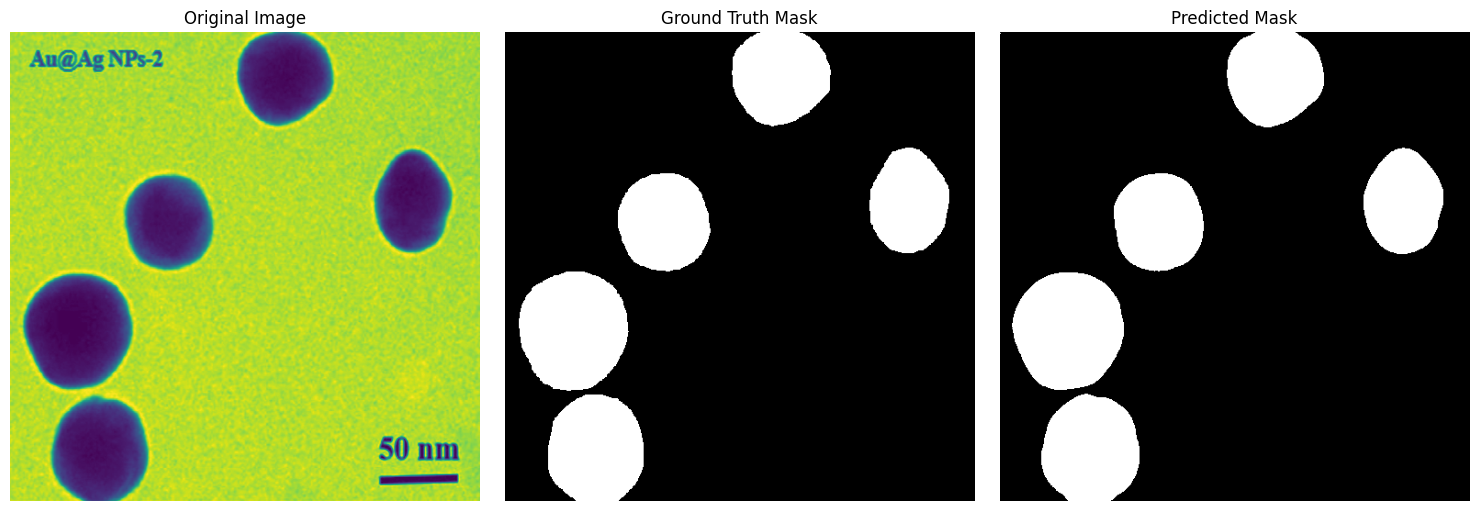

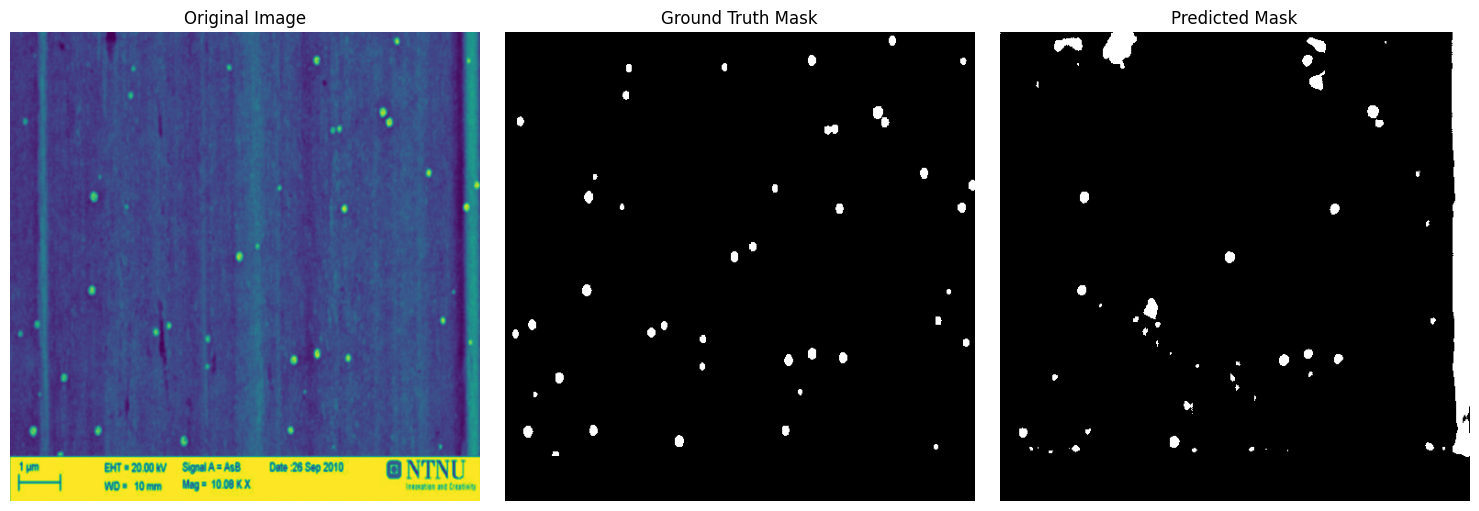

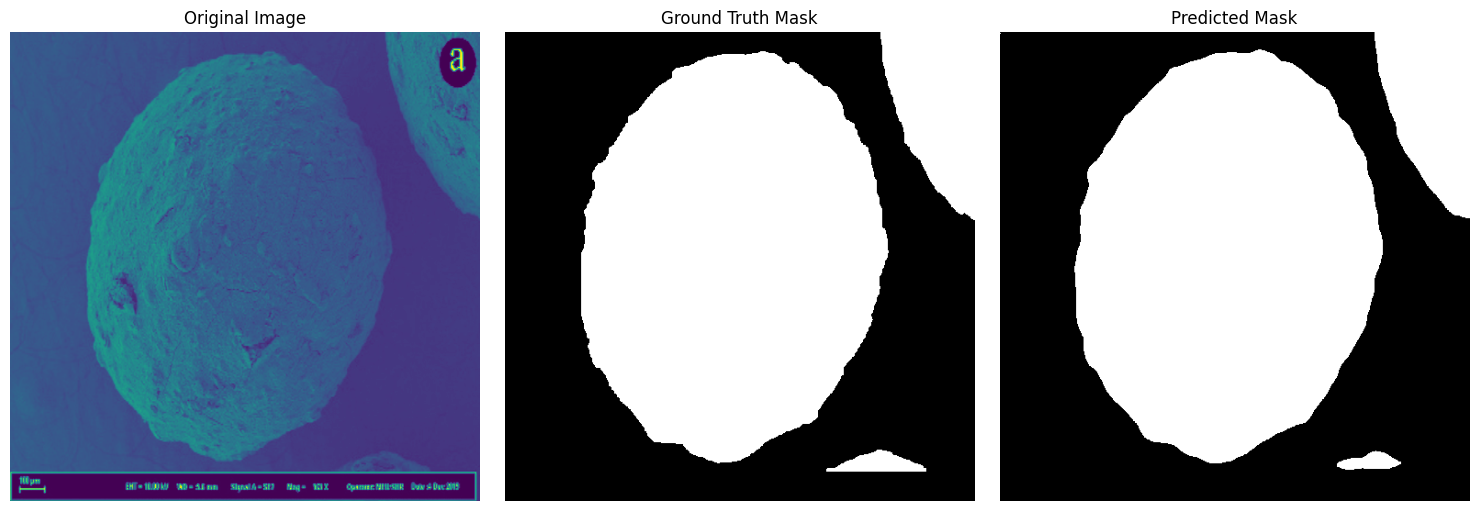

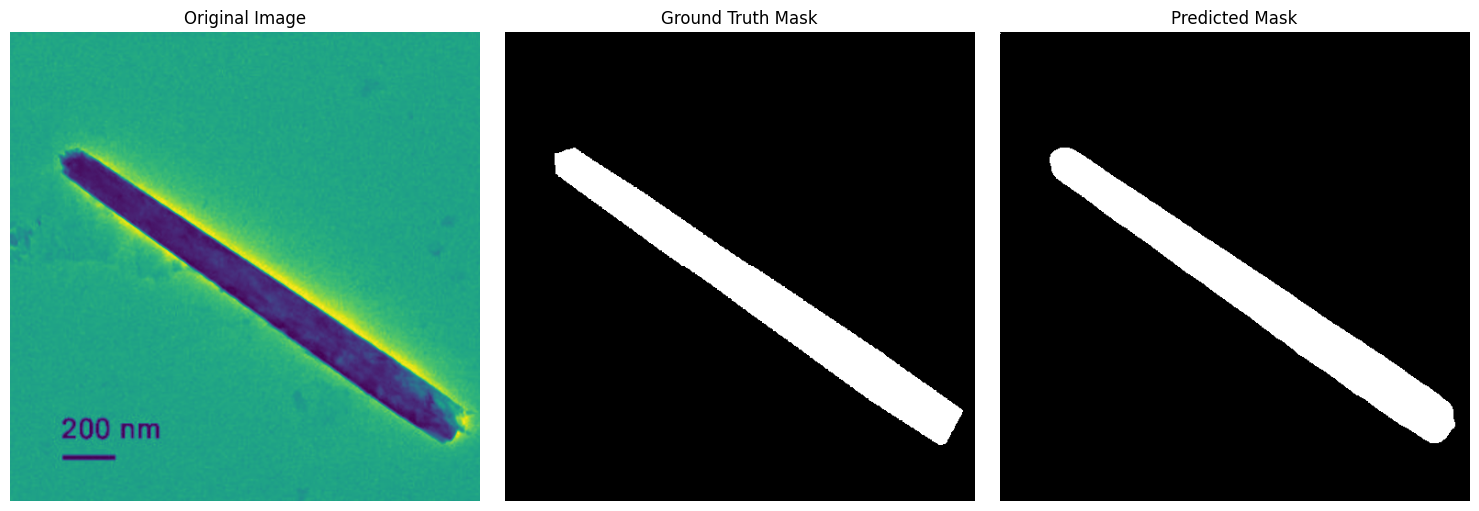

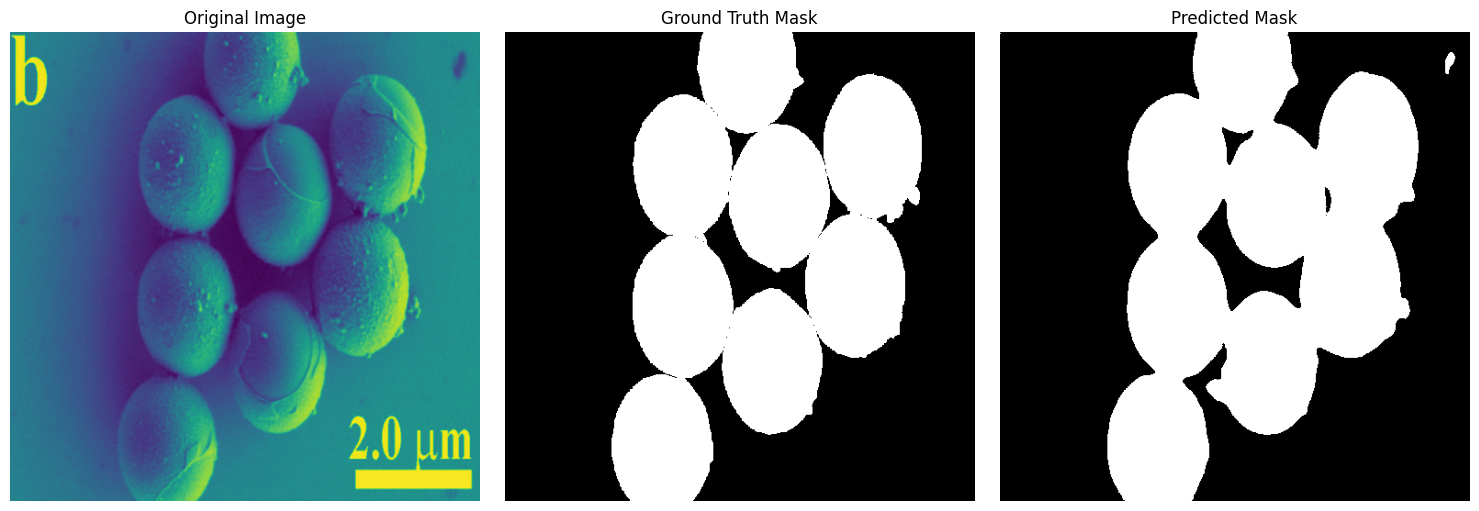

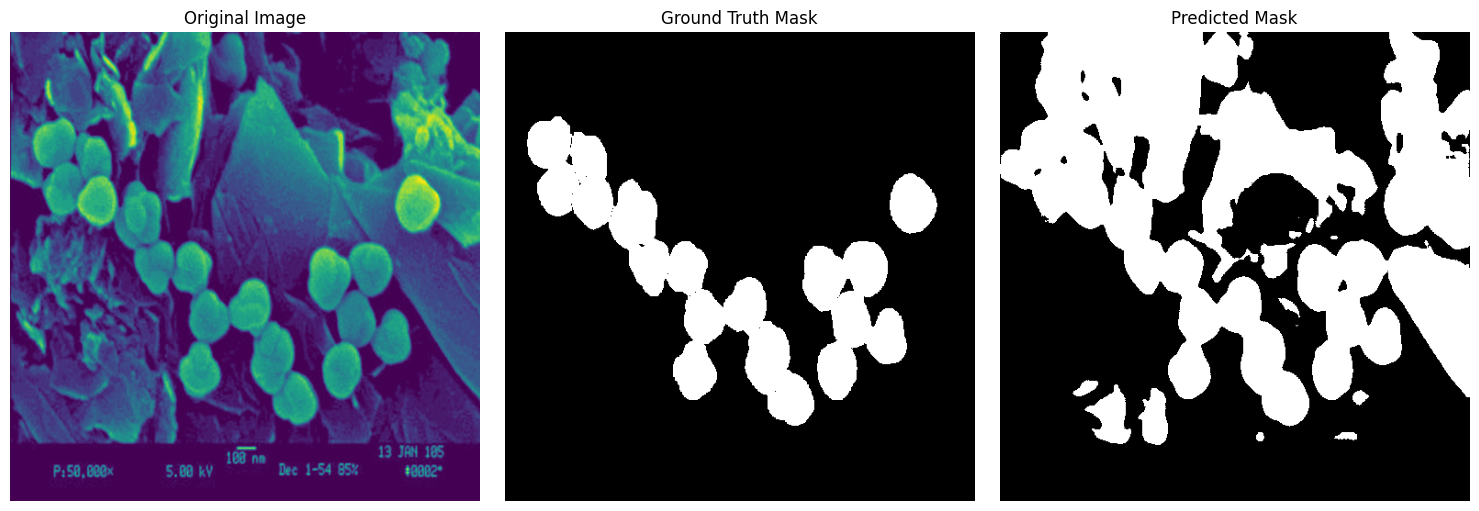

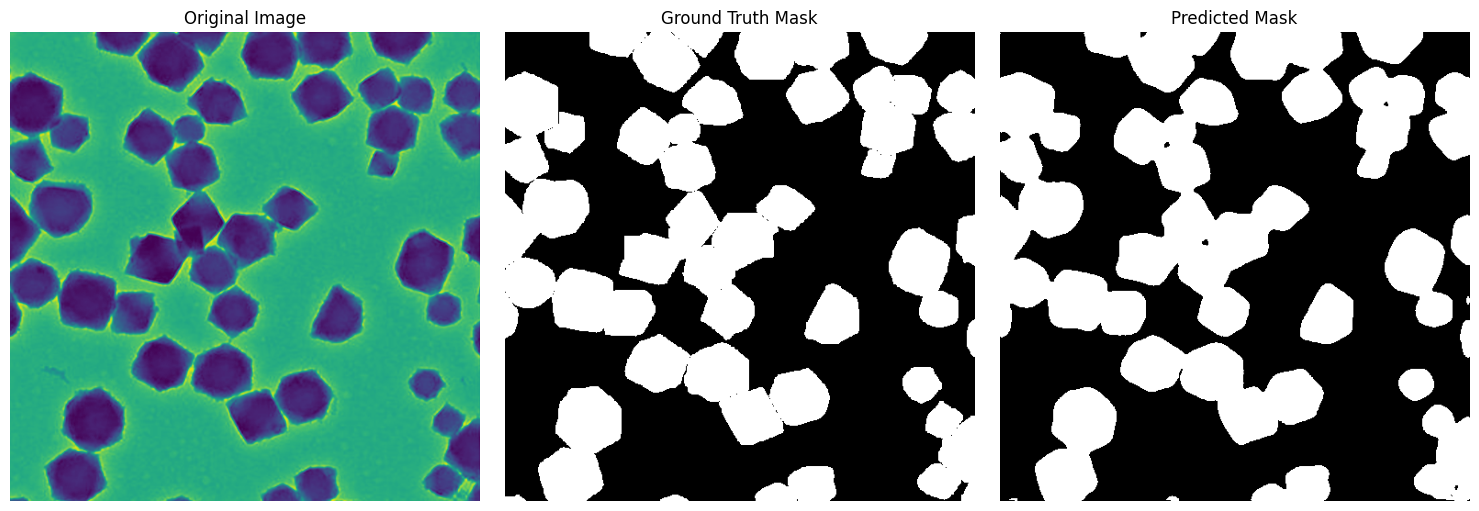

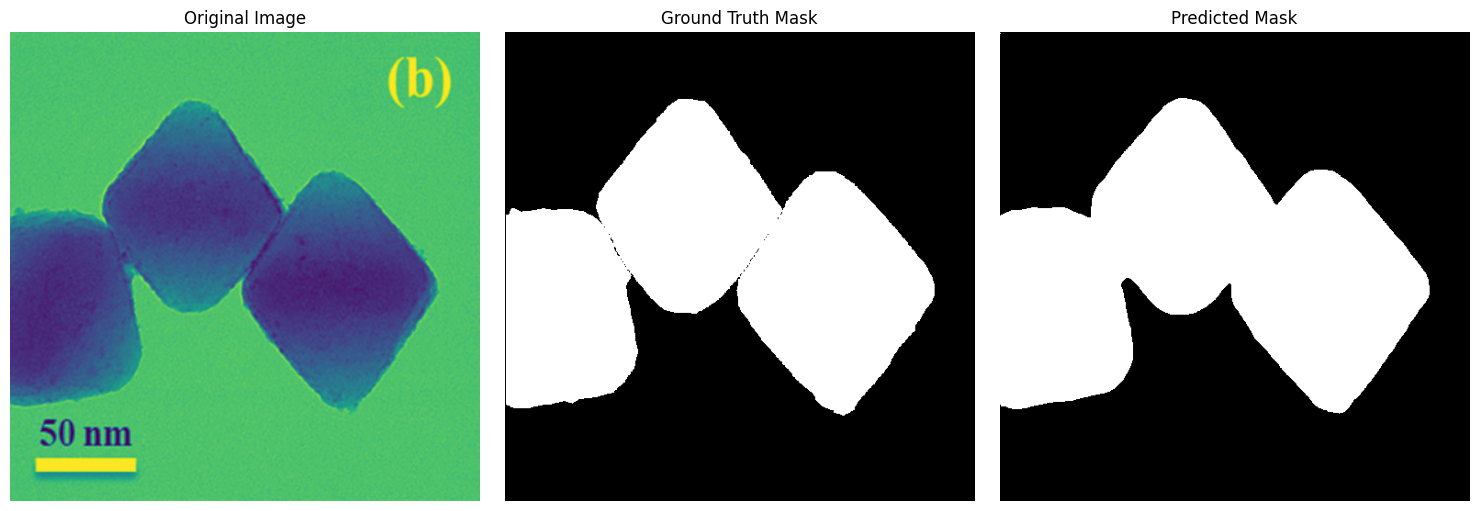

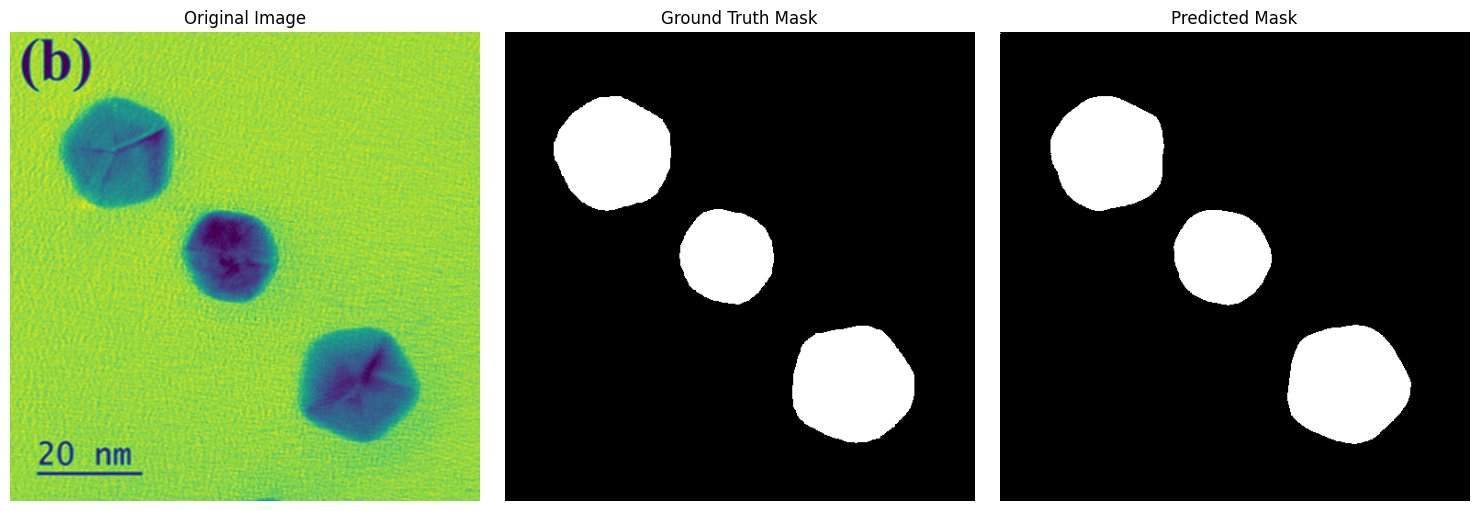

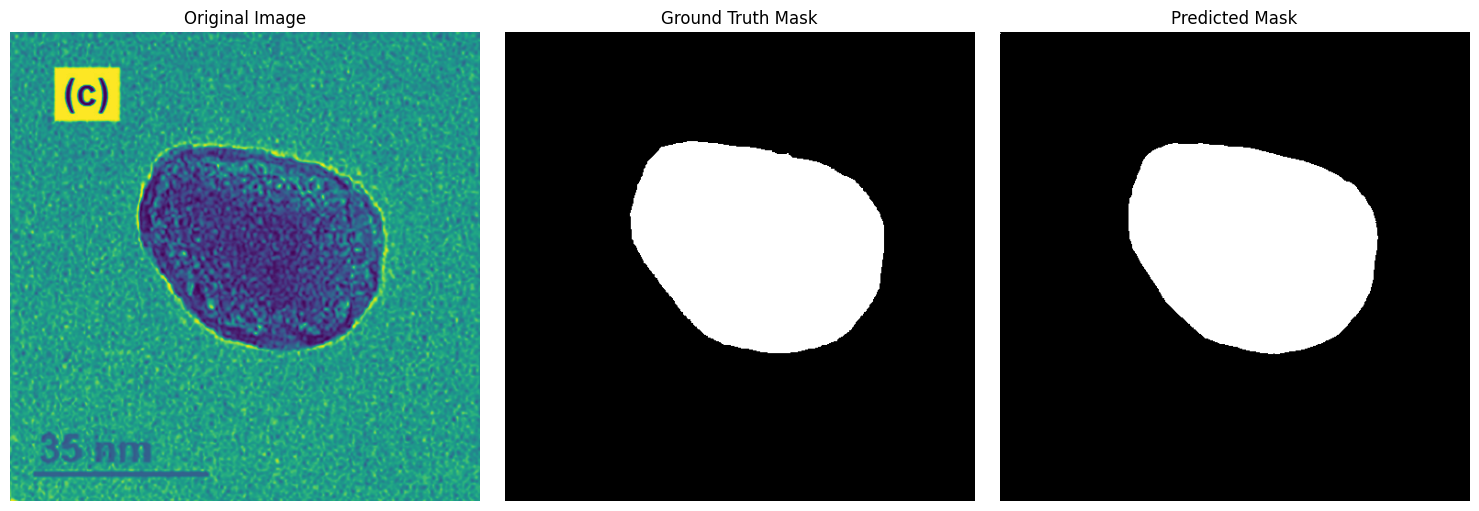

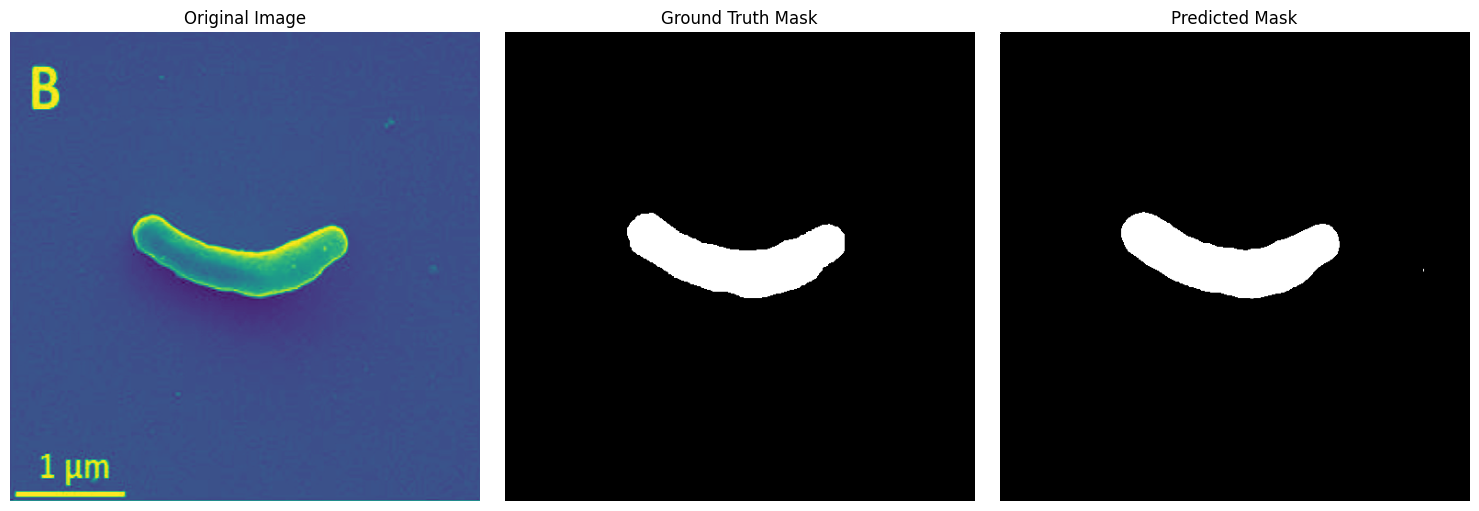

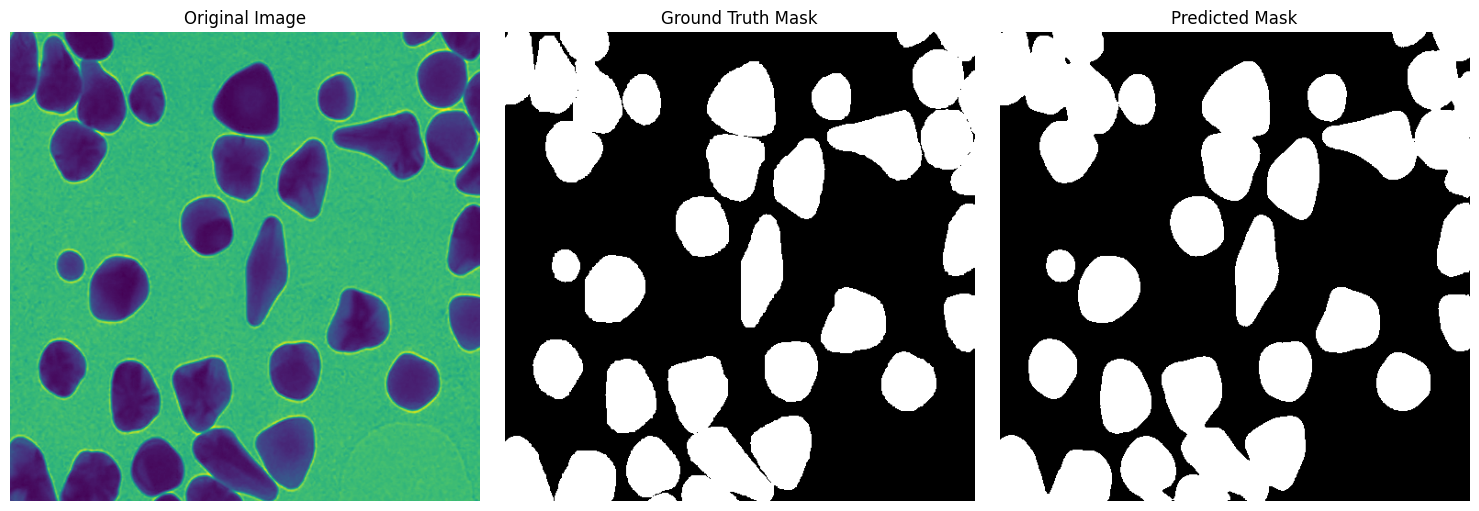

In [16]:
# Set the model to evaluation mode
model.eval()

# Get a batch of images and masks from the test loader
images, masks = next(iter(test_loader))
images = images.to(config.device)
masks = masks.to(config.device)

# Run the model on the images
with torch.no_grad():
    outputs = model(images)
    if isinstance(outputs, dict):
        outputs = outputs['out']
    outputs = outputs.squeeze(1)  # Remove channel dimension if necessary

    # Apply sigmoid activation to get probabilities between 0 and 1
    probs = torch.sigmoid(outputs)

# Threshold probabilities to get binary masks
pred_masks = (probs > 0.5).float()

# Move data to CPU and convert to NumPy arrays for plotting
images = images.cpu()
masks = masks.cpu()
pred_masks = pred_masks.cpu()

# Denormalize images for visualization if you normalized them during preprocessing
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])   # ImageNet std

batch_size = images.shape[0]

for i in range(batch_size):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    img = images[i].permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
    #img = img * std + mean  # Denormalize
    #img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground Truth Mask
    gt_mask = masks[i].numpy()
    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted Mask
    pred_mask = pred_masks[i].numpy()
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    #plt.savefig(f"epoch_{epoch+1}_image_{i}.png")
    plt.tight_layout()
    plt.show()


In [17]:
import pandas as pd
data = {
    "epoch": epochs,
    "train_loss": train_loss_data,
    "val_loss": val_loss_data,
    "precision": precision_data,
    "recall": recall_data,
    "accuracy": accuracy_data,
    "iou": iou_data,
    "f1": f1_data,
    "dice_coeff": dice_coeff_data,
    "rand_error": rand_error_data,
    "pixel_error": pixel_error_data
}

metrics_df = pd.DataFrame(data)
print(metrics_df)
metrics_df.to_csv("training_metrics.csv", index=False)

    epoch  train_loss  val_loss  precision    recall  accuracy       iou  \
0       1    7.397663  7.762245   0.320135  1.000000  0.320135  0.317569   
1       2    7.163452  7.680178   0.320648  0.999052  0.322076  0.317959   
2       3    6.397906  6.776643   0.557080  0.955752  0.742566  0.540135   
3       4    5.348854  5.391486   0.855549  0.968436  0.937550  0.829393   
4       5    4.721920  5.108370   0.886867  0.965869  0.949629  0.857281   
5       6    4.359681  4.365400   0.885817  0.974970  0.951754  0.863371   
6       7    4.063925  4.135137   0.929511  0.961867  0.964441  0.891992   
7       8    3.866128  3.492072   0.913738  0.981736  0.964483  0.896655   
8       9    3.633782  3.674557   0.908453  0.987541  0.964153  0.895654   
9      10    3.502477  3.535381   0.923381  0.970180  0.964682  0.898330   
10     11    3.437372  3.408174   0.941025  0.966591  0.969912  0.911071   
11     12    3.288241  3.310231   0.924064  0.981040  0.968121  0.906827   
12     13   